In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re

from textblob import TextBlob
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Lambda
from keras.backend import mean
from keras.utils import to_categorical
from keras import optimizers, initializers

from load_glove_embeddings import load_glove_embeddings

In [4]:
#nltk.download('stopwords')
#nltk.download('wordnet')

In [5]:
def preprocess(words, to_lowercase=True, remove_punctuation=True, remove_digits=True, 
               remove_odd_chars=True, remove_stopwords=True, stem=False, spell_check=False,
               lemmatize=False):
    
    if to_lowercase:
        words = [w.lower() for w in words]
    
    if remove_punctuation:
        words = [w for w in words if not (re.match(r'^\W+$', w) != None)]
    
    if remove_digits:
        words = [w for w in words if not w.replace('.','',1).isdigit()]

    if remove_odd_chars:
        words = [re.sub(r'[^a-zA-Z0-9_]','', w) for w in words]
    
    if remove_stopwords:
        sw = set(nltk.corpus.stopwords.words("english"))
        words = [w for w in words if not w in sw]

    if spell_check:
        words = [str(TextBlob(w).correct()) for w in words]
     
    if stem:
        porter = nltk.PorterStemmer()
        words = [porter.stem(w) for w in words]

    if lemmatize:
        wordnet = nltk.WordNetLemmatizer()
        words = [wordnet.lemmatize(w) for w in words]
        
    return words

def lookup_index(docs):
    output_matrix = []
    for d in docs:
        indices = []
        for w in d:
            if w in word2index.keys():
                indices.append(word2index[w])
            else:
                indices.append(word2index['unk'])
        output_matrix.append(indices)
    return output_matrix

In [7]:
df = pd.read_csv('jokes_dataset_CLEAN.csv')
df.head()

,Unnamed: 0,body,id,score,title
0,0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore
1,1,Pizza doesn't scream when you put it in the ov...,5tz4dd,0,What's the difference between a Jew in Nazi Ge...
2,4,He got caught trying to sell the two books to ...,5tz1pc,0,You hear about the University book store worke...
3,5,Because the p is silent.,5tz1o1,0,Why is it unknown on how pterodactyls urinate ...
4,6,To avoid leaving tracks like a snail while wal...,5tz0ef,0,Why women need legs?


In [28]:
df['class'] = [0 if df.score[i] <= 3 \
               else 1 if (df.score[i] > 3 and df.score[i] <= 50) \
               else 2 if (df.score[i] > 50 and df.score[i] <= 200) \
               else 3 for i in range(df.shape[0])]

(0, 1000)

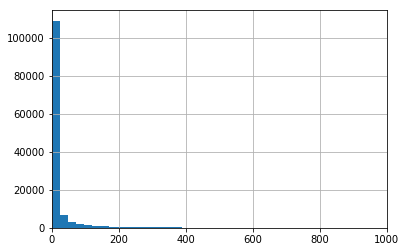

In [11]:
df.score.hist(bins=2000)
plt.xlim(0,1000)

In [29]:
docs = [str(df.title[i]) + ' ' + str(df.body[i]) for i in range(df.shape[0])]

In [31]:
word2index, embedding_matrix = load_glove_embeddings('C:/Users/Eanna/Documents/Masters/NLP/Assignment3/data/glove.6B.300d.txt', embedding_dim=300)

In [32]:
docs_cleaned = [preprocess(words.split()) for words in docs]

In [33]:
docs_encoded = lookup_index(docs_cleaned)

In [34]:
docs_padded = pad_sequences(docs_encoded, maxlen=60, padding='post')

In [54]:
initializers.glorot_uniform()

embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1], 
                            input_length=60,
                            weights=[embedding_matrix], 
                            trainable=False,
                            mask_zero=True,
                            name='embedding_layer')

model = Sequential()
model.add(embedding_layer)
model.add(Lambda(lambda x: mean(x, axis=1)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [65]:
from keras import backend as K


def precision(y_true, y_pred):	
    """Precision metric.	
    Only computes a batch-wise average of precision. Computes the precision, a
    metric for multi-label classification of how many selected items are
    relevant.
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))	
    precision = true_positives / (predicted_positives + K.epsilon())	
    return precision

def recall(y_true, y_pred):	
    """Recall metric.	
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))	
    recall = true_positives / (possible_positives + K.epsilon())	
    return recall

def f1_score(y_true, y_pred):
    """Computes the F1 Score
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return (2 * p * r) / (p + r + K.epsilon())

In [68]:
adam = optimizers.adam(lr=0.1)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[precision, recall, f1_score])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 60, 300)           120000300 
_________________________________________________________________
lambda_4 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               154112    
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
__________

In [69]:
model.fit(docs_padded, to_categorical(df['class']), epochs=10)

Epoch 1/10
130763/130763 [==============================] - 80s 612us/step - loss: 1.0080 - precision: 0.5542 - recall: 0.5542 - f1_score: 0.5542
Epoch 2/10
130763/130763 [==============================] - 79s 603us/step - loss: 1.0081 - precision: 0.5619 - recall: 0.5619 - f1_score: 0.5619
Epoch 3/10
130763/130763 [==============================] - 104s 799us/step - loss: 1.0081 - precision: 0.5540 - recall: 0.5540 - f1_score: 0.5540
Epoch 4/10
 95680/130763 [====================>.........] - ETA: 30s - loss: 1.0089 - precision: 0.5551 - recall: 0.5551 - f1_score: 0.5551

KeyboardInterrupt: 

In [52]:
model.evaluate(docs_padded, to_categorical(df.score))

MemoryError: 